# Image Segmentation with U-Net

You'll be building your own U-Net, a type of CNN designed for quick, precise image segmentation, and using it to predict a label for every single pixel in an image - in this case, an image from a self-driving car dataset. 

This type of image classification is called semantic image segmentation. It's similar to object detection in that both ask the question: "What objects are in this image and where in the image are those objects located?," but where object detection labels objects with bounding boxes that may include pixels that aren't part of the object, semantic image segmentation allows you to predict a precise mask for each object in the image by labeling each pixel in the image with its corresponding class. The word “semantic” here refers to what's being shown, so for example the “Car” class is indicated below by the dark blue mask, and "Person" is indicated with a red mask:

<img src="images/carseg.png" style="width:500px;height:250;">
<caption><center> <u><b>Figure 1</u></b>: Example of a segmented image <br> </center></caption>

As you might imagine, region-specific labeling is a pretty crucial consideration for self-driving cars, which require a pixel-perfect understanding of their environment so they can change lanes and avoid other cars, or any number of traffic obstacles that can put peoples' lives in danger. 


In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

from test_utils import summary, comparator

2023-01-31 11:20:43.580042: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-31 11:20:43.752500: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-31 11:20:43.752530: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-31 11:20:44.758826: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

<a name='2'></a>
## 2 - Load and Split the Data

In [3]:
img_path="data/dataA/dataA/CameraRGB/"
mask_path="data/dataA/dataA/CameraSeg/"

img_list,mask_list=[],[]

for img_name in os.listdir(img_path):
    if os.path.exists(mask_path+img_name) and img_name[-4:] == '.png':
        img_list.append( img_path+img_name )
        mask_list.append( mask_path+img_name )

### Check out the some of the unmasked and masked images from the dataset:

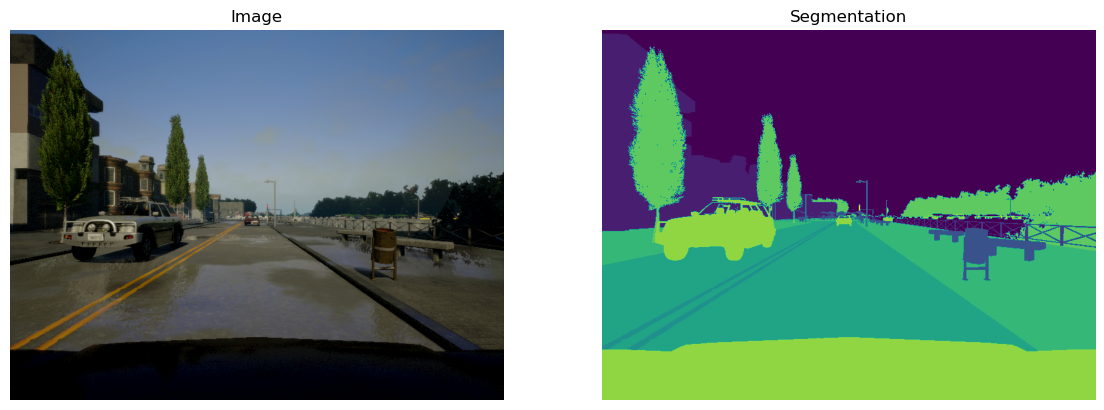

In [4]:
n=np.random.randint(0,len(img_list))
img=plt.imread(img_list[n])
mask=plt.imread(mask_list[n])
mask=np.max(mask,axis=-1)

fig,ax=plt.subplots(1,2,figsize=(14, 10))

ax[0].imshow(img)
ax[0].set_title("Image")
ax[0].set_axis_off()

ax[1].imshow(mask)
ax[1].set_title("Segmentation")
ax[1].set_axis_off()

<a name='2-1'></a>
### 2.1 - Split Your Dataset into Unmasked and Masked Images

In [5]:
image_list_ds=tf.data.Dataset.list_files(img_list,shuffle=False)
mask_list_ds=tf.data.Dataset.list_files(mask_list,shuffle=False)

for path in zip(image_list_ds.take(3),mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'data/dataA/dataA/CameraRGB/02_00_000.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data/dataA/dataA/CameraSeg/02_00_000.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'data/dataA/dataA/CameraRGB/02_00_001.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data/dataA/dataA/CameraSeg/02_00_001.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'data/dataA/dataA/CameraRGB/02_00_010.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data/dataA/dataA/CameraSeg/02_00_010.png'>)


2023-01-31 11:20:46.982735: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-31 11:20:46.982785: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-31 11:20:46.982819: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (21f67fcf6368): /proc/driver/nvidia/version does not exist
2023-01-31 11:20:46.983208: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
image_filenames=tf.constant(img_list)
mask_filenames=tf.constant(mask_list)

dataset=tf.data.Dataset.from_tensor_slices((image_filenames,mask_filenames))
for img,msk in dataset.take(1):
    print(img)
    print(msk)

tf.Tensor(b'data/dataA/dataA/CameraRGB/06_00_090.png', shape=(), dtype=string)
tf.Tensor(b'data/dataA/dataA/CameraSeg/06_00_090.png', shape=(), dtype=string)


<a name='2-2'></a>
### 2.2 - Preprocess Your Data

In [7]:
def process_path(image_path,mask_path):
    image=tf.io.read_file(image_path)
    image=tf.image.decode_png(image,channels=3)
    image=tf.image.convert_image_dtype(image,tf.float32)
    
    mask=tf.io.read_file(mask_path)
    mask=tf.image.decode_png(mask,channels=3)
    mask=tf.reduce_max(mask,axis=-1,keepdims=True)
    
    return image,mask

def process(image,mask):
    input_image=tf.image.resize(image,(96,128),method="nearest")
    input_mask=tf.image.resize(mask,(96,128),method="nearest")
    
    input_image=input_image/255
    
    return input_image,input_mask

image_ds=dataset.map(process_path)
processed_image_ds=image_ds.map(process)

<a name='3-1'></a>
### 3.1 - Model Details

<img src="images/unet.png" style="width:700px;height:400;">
<caption><center> <u><b> Figure 2 </u></b>: U-Net Architecture<br> </center></caption>

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 unpadded convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection. 

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class. 

The U-Net network has 23 convolutional layers in total. 

<a name='3-2'></a>
### 3.2 - Encoder (Downsampling Block) 

<img src="images/encoder.png" style="width:500px;height:500;">
<caption><center> <u><b>Figure 3</u></b>: The U-Net Encoder up close <br> </center></caption>

The encoder is a stack of various conv_blocks

In [8]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """
    
    conv=Conv2D(n_filters,3,activation="relu",padding="same",kernel_initializer="he_normal")(inputs)
    conv=Conv2D(n_filters,3,activation="relu",padding="same",kernel_initializer="he_normal")(conv)
    
    if dropout_prob>0:
        conv=Dropout(dropout_prob)(conv)
    
    if max_pooling==True:
        next_layer=MaxPooling2D(2,strides=(2,2))(conv)
    else:
        next_layer=conv
        
    skip_connection=conv
    
    return next_layer,skip_connection

<a name='3-3'></a>
### 3.3 - Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, you'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

<img src="images/decoder.png" style="width:500px;height:500;">
<caption><center> <u><b>Figure 4</u></b>: The U-Net Decoder up close <br> </center></caption>

There are two new components in the decoder: `up` and `merge`. These are the transpose convolution and the skip connections. In addition, there are two more convolutional layers set to the same parameters as in the encoder. 

Here you'll encounter the `Conv2DTranspose` layer, which performs the inverse of the `Conv2D` layer. You can read more about it [here.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)




In [9]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    up=Conv2DTranspose(n_filters,3,strides=2,padding='same')(expansive_input)
    
    merge=concatenate([up,contractive_input],axis=3)
    
    conv=Conv2D(n_filters,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge)
    conv=Conv2D(n_filters,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv)
    
    return conv

###  Build the Model

This is where you'll put it all together, by chaining the encoder, bottleneck, and decoder! You'll need to specify the number of output channels, which for this particular set would be 23. That's because there are 23 possible labels for each pixel in this self-driving car dataset.

In [11]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs=Input(shape=input_size)
    
    cblock1=conv_block(inputs=inputs,n_filters=n_filters*1)
    cblock2=conv_block(inputs=cblock1[0],n_filters=n_filters*2)
    cblock3=conv_block(inputs=cblock2[0],n_filters=n_filters*4)
    cblock4=conv_block(inputs=cblock3[0],n_filters=n_filters*8,dropout_prob=0.3)
    
    cblock5=conv_block(inputs=cblock4[0],n_filters=n_filters*16,dropout_prob=0.3,max_pooling=False)
    
    ublock6=upsampling_block(cblock5[0],cblock4[1], n_filters*8)
    ublock7=upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8=upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9=upsampling_block(ublock8, cblock1[1], n_filters*1)
    
    conv9=Conv2D(n_filters,3,activation='relu',padding='same',kernel_initializer='he_normal')(ublock9)
    conv10=Conv2D(n_classes,1,padding='same')(conv9)
    
    model=tf.keras.Model(inputs=inputs,outputs=conv10)
    return model

In [13]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [14]:
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_22 (Conv2D)             (None, 96, 128, 32)  896         ['input_4[0][0]']                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 96, 128, 32)  9248        ['conv2d_22[0][0]']              
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 48, 64, 32)  0           ['conv2d_23[0][0]']        

In [37]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
def display(display_list):
    plt.figure(figsize=(14, 10))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(600, 800, 1)


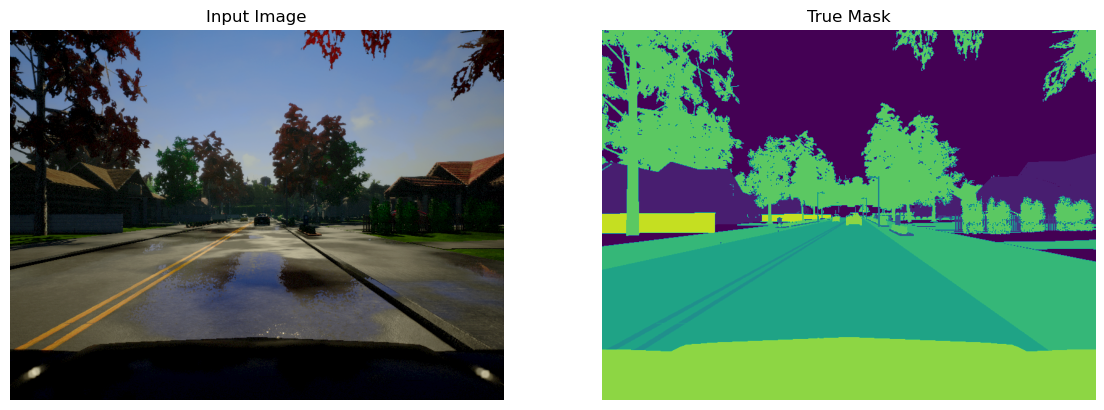

In [42]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


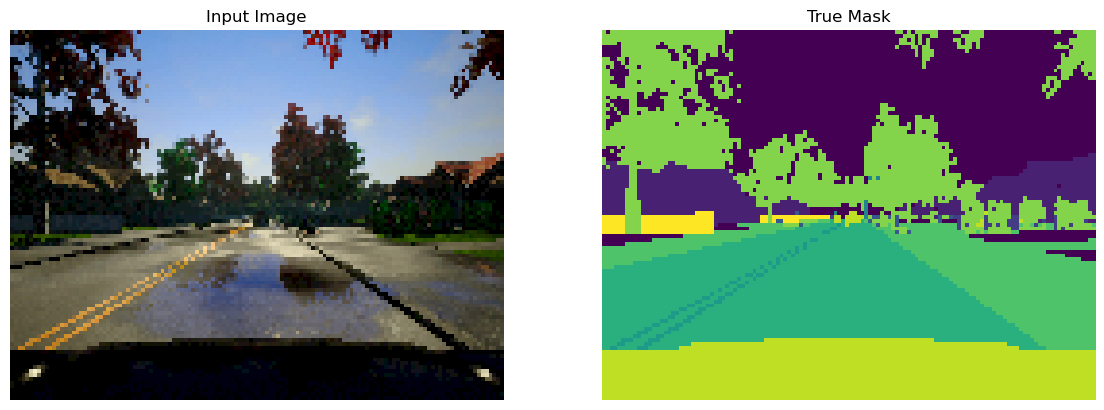

In [43]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [ ]:
EPOCHS = 40
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40
34/34 [==============================] - 19s 560ms/step - loss: 2.7772 - accuracy: 0.3369
Epoch 2/40
34/34 [==============================] - 1s 41ms/step - loss: 1.6944 - accuracy: 0.4333
Epoch 3/40
34/34 [==============================] - 1s 40ms/step - loss: 1.3061 - accuracy: 0.5917
Epoch 4/40
34/34 [==============================] - 1s 40ms/step - loss: 0.8349 - accuracy: 0.7610
Epoch 5/40
 1/34 [..............................] - ETA: 0s - loss: 0.7798 - accuracy: 0.7612

<a name='4-1'></a>
### Create Predicted Masks 


In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

<a name='4-3'></a>
###  Show Predictions 


In [ ]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
 

In [ ]:
show_predictions(train_dataset, 6)